In [2]:
import numpy as np
import matplotlib.pyplot as plt

## 1 Set up the model


Our equilibrium conditions:

$$
\textbf{F}_t(\textbf{X}, Z) \equiv 
\begin{pmatrix}
\frac{W_t}{P_t}-\frac{\chi N_t^\varphi}{C_t^{-\gamma}}
\\
1-\beta E_t \{Q_t \frac{P_t}{P_{t+1}} \frac{C_{t+1}^{-\gamma}}{C_{t}^{-\gamma}}\} 
\\
1-\theta \pi_t^{\epsilon-1}-(1-\theta){p^*_t}^{1-\epsilon}
\\
p^*_t-E_t(F_{1t}/F_{2t})
\\
\Lambda_{t,t+1}- \beta E_t ( \frac{C_{t+1}^{-\gamma}}{C_{t}^{-\gamma}} )
\\
Y_t-C_t
\\
Y_t-A_tN_t
\\
Q_t-\beta^{-1} \pi_t^{\phi_\pi} e^{v_t} 
\\
E_t R_{t+1} - E_t(Q_t \pi_{t+1}^{-1})
\\
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{pmatrix},
\qquad t = 0, 1, \dots 
\tag{1}
$$
where $\textbf{X} = \{C, W/P, \pi, p^*, \Lambda, R, N, Q, Y\}$ denotes the set of endogenous variables. $A$ and $v$ are the exogenous variables. 

Blocks

In [3]:
from sequence_jacobian import simple, create_model, solved

@simple 
def HH (N, C, gamma, varphi, chi, beta):
 WP = chi * (N ** varphi) / (C ** (-gamma))
 S = beta * (C(+1) ** (- gamma)) / (C ** (- gamma)) 
 EtRt1 = 1 / (beta * (C(+1) ** (-gamma)) / (C ** (-gamma) ))
 return WP, S, EtRt1

@solved(unknowns={'f1': 1.25, 'f2': 1.25}, targets=['f1eq','f2eq'], solver="broyden_custom")
def firms (f1, f2, mu, N, WP, theta, pi, S, e, A):
   Y = A * N
   f1eq = ((1 + mu) *  N * WP ) + theta * (pi(+1) ** e)  * S * f1(+1) - f1
   f2eq =  A * N + theta * S * f2(+1) * (pi(+1) ** (e - 1)) - f2
   pstar = f1 / f2
   return Y, pstar, f1eq, f2eq


@simple
def central_bank(pi, phi_pi, beta):
    Q = (pi ** (phi_pi)) / beta  # taylor rule with phi_y=0
    return Q

@simple
def mkt_clearing(Y, Q, pi, C, EtRt1, pstar, theta, e):
    goods_mkt = Y - C
    inflation = 1 - theta * (pi ** (e - 1)) - (1 - theta) * (pstar ** (1-e))
    fisher = EtRt1 - Q  / pi(+1) 
    return goods_mkt, inflation, fisher



Create model

In [4]:
nk = create_model([HH, firms, central_bank, mkt_clearing], name="NK")

print(nk)
print(f"Blocks: {nk.blocks}")

<Model 'NK'>
Blocks: [<SimpleBlock 'central_bank'>, <SimpleBlock 'HH'>, <SolvedBlock 'firms'>, <SimpleBlock 'mkt_clearing'>]


DAG representation

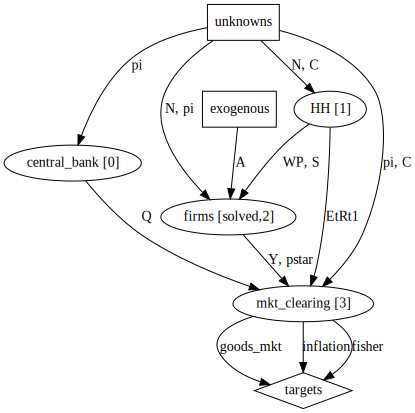

In [5]:
from sequence_jacobian.utilities.drawdag import drawdag


unknowns = ['pi', 'N', 'C']
targets = ['goods_mkt','inflation', 'fisher']
inputs = ['A']

drawdag(nk, inputs, unknowns, targets, save="nkj.png")

Parameters

In [6]:
# parameters
gamma = 1.0
beta = 0.99
phi_pi = 1.5
e = 10.0 
mu = 1 / (e-1)
chi = 1.0
theta = 0.25  
varphi = 1.0

## 2 Steady State

In [7]:
#calibration = {'A': 1., 'Y': 1., 'Q': 1/beta, 'EtRt1': 1/beta, 'S': 1,'WP':chi, 'gamma': gamma, 'beta': beta, 'phi_pi': phi_pi, 'varphi': varphi, 'chi': chi, 'mu': mu, 'theta': theta, 'e': e}

calibration = {'C': 1, 'WP': 1, 'Pi': 1, 'pstar': 1, 'S': 1, 'N': 1, 'Q': 1, 
                   'Y': 1, 'EtRt1': 1, 
                   'gamma': gamma, 'beta': beta, 'phi_pi': phi_pi, 'e': e, 
                   'mu': mu, 'varphi': varphi, 'chi': chi, 'theta': theta, 'A':1}


unknowns_ss = {'pi': 1., 'N': 1., 'C': 1.}
targets_ss = {"goods_mkt": 0, "inflation": 0, "fisher": 0}


ss = nk.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="broyden_custom")

# Print steady-state result
print("Steady-state values:")
for key, value in ss.items(): 
    print(f"{key}: {value}")

# checking that we are in the steady state that we expect
#assert np.allclose(ss['pi'], 0)
#assert np.allclose(ss['euler'], 0)

print(ss)

Steady-state values:
C: 0.948683298050514
WP: 0.9000000000000004
Pi: 1
pstar: 1.0000000000000004
S: 0.99
N: 0.948683298050514
Q: 1.0101010101010097
Y: 0.948683298050514
EtRt1: 1.0101010101010102
gamma: 1.0
beta: 0.99
phi_pi: 1.5
e: 10.0
mu: 0.1111111111111111
varphi: 1.0
chi: 1.0
theta: 0.25
A: 1
pi: 0.9999999999999997
f1: 1.2607087017282452
f2: 1.2607087017282448
f1eq: 8.881784197001252e-15
f2eq: 8.881784197001252e-15
goods_mkt: 0.0
inflation: 3.774758283725532e-15
fisher: 0.0
<SteadyStateDict: ['C', 'WP', 'Pi', 'pstar', 'S', 'N', 'Q', 'Y', 'EtRt1', 'gamma', 'beta', 'phi_pi', 'e', 'mu', 'varphi', 'chi', 'theta', 'A', 'pi', 'f1', 'f2', 'f1eq', 'f2eq', 'goods_mkt', 'inflation', 'fisher']>


## 3 Solution

Note that in practice, this method computes a first order aproximation to the nonlinear solution. 

In [8]:
G = nk.solve_jacobian(ss, unknowns, targets, inputs, T=300)

print(G)

<JacobianDict outputs=['pi', 'N', 'C', 'WP', 'S', 'EtRt1', 'Y', 'pstar', 'f1eq', 'f2eq', 'f2', 'f1', 'Q', 'goods_mkt', 'inflation', 'fisher'], inputs=['A']>


TFP shock:

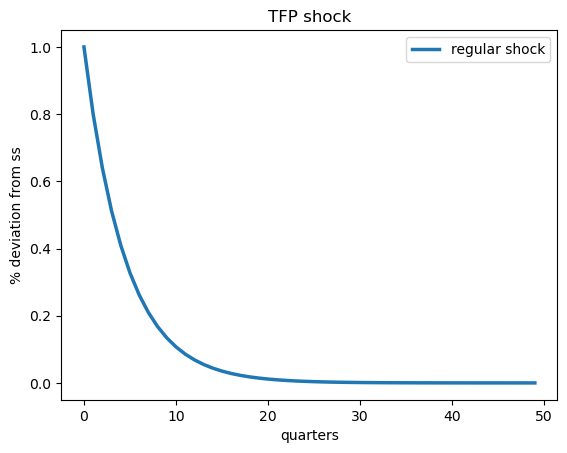

In [9]:
T, Tplot, impact, rho, news = 300, 20, 0.01, 0.8, 10
dA = np.empty((T, 1))
dA[:, 0] = impact * rho**np.arange(T)

plt.plot(100*dA[:50, 0]/ss['A'], label='regular shock', linewidth=2.5)
plt.title(r'TFP shock')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.legend()
plt.show()


Apply G matrix to map this impulse to response on other variables by 1st order aproximation

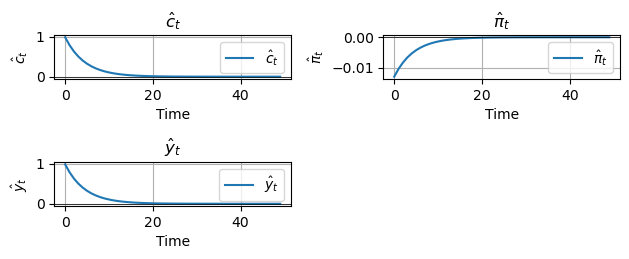

In [10]:
dC = 100 * G['C']['A'] @ dA / ss['C']
dN = 100 * G['N']['A'] @ dA / ss['N']
dY = 100 * G['Y']['A'] @ dA / ss['Y']

variables = [dC[:50, 0], dN[:50, 0], dY[:50, 0]]
labels = ['$\\hat{c}_t$', '$\\hat{\\pi}_t$',  '$\\hat{y}_t$']

for i, (var, label) in enumerate(zip(variables, labels)):
    plt.subplot(4, 2, i + 1)
    plt.plot(var, label=label)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.title(label)
    plt.xlabel('Time')
    plt.ylabel(label)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()